In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV


In [14]:
df = pd.read_csv('caravan.csv')

df.describe()

total_features = {feature: 0 for feature in df.columns}

In [15]:
missing_values_per_column = df.isnull().sum()

for i in range(len(missing_values_per_column)):
    if missing_values_per_column.iloc[i] > 0:
        print(missing_values_per_column.index[i], missing_values_per_column.iloc[i])
    
    
# no missing values

Index(['Customer Subtype', 'High level education', 'Rented house',
       'Home owners', 'Contribution car policies',
       'Contribution fire policies', 'Contribution boat policies',
       'Contribution social security insurance policies',
       'Number of car policies', 'Number of boat policies'],
      dtype='object')


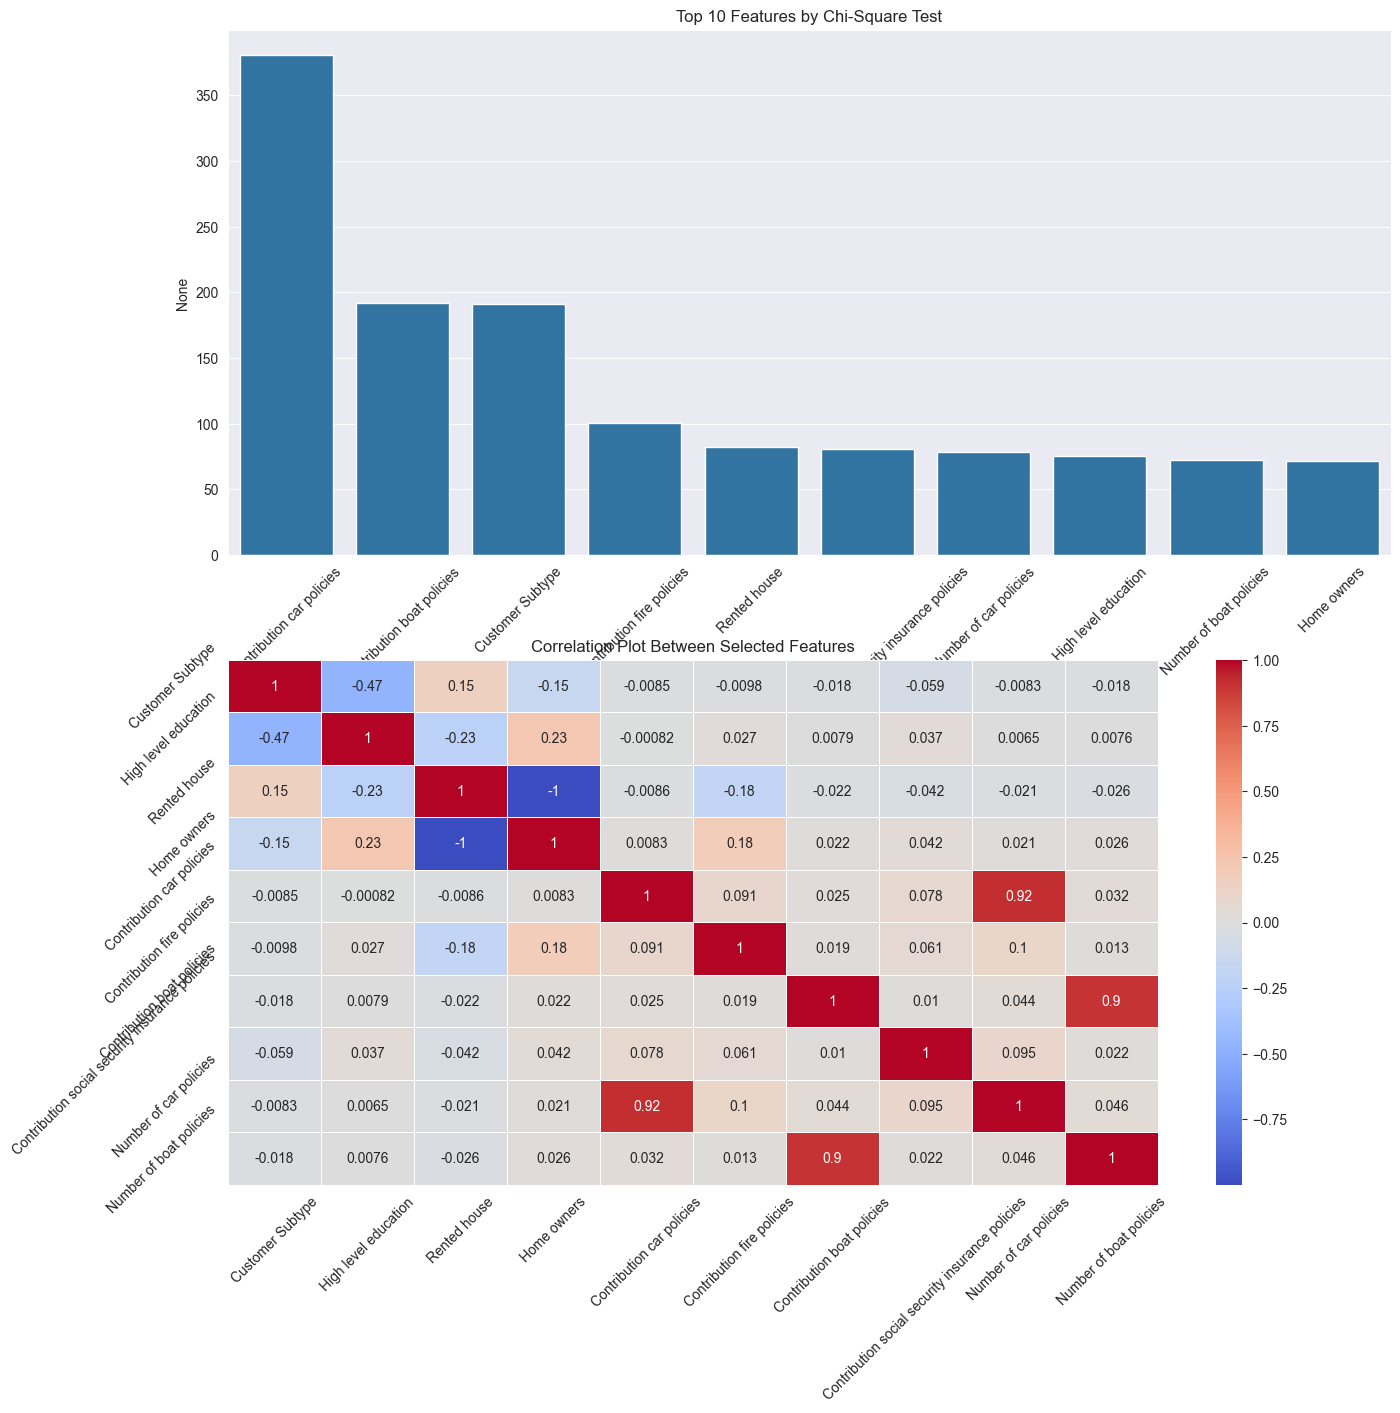

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


# looking at feature documentation shows that all the features are categorical. We can try a chi-squared test to get a preliminary selection:

X = df.drop(columns='CARAVAN POLICY')
y = df['CARAVAN POLICY']

chi2_selector = SelectKBest(chi2, k=10)
X_kbest = chi2_selector.fit_transform(X, y)

selected_features = X.columns[chi2_selector.get_support()]
print(selected_features)

chi2_scores = pd.Series(chi2_selector.scores_, index=X.columns).sort_values(ascending=False).head(10)


plt.figure(figsize=(15,15))

plt.subplot(2, 1, 1)
sns.barplot(x=chi2_scores.index, y=chi2_scores)
plt.title('Top 10 Features by Chi-Square Test')
plt.xticks(rotation=45)


reduced_x = X[selected_features]
corr_matrix = reduced_x.corr()

plt.subplot(2, 1, 2)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Plot Between Selected Features')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

for feature in selected_features:
    total_features[feature] += 1




Index(['Customer Subtype', 'Protestant', 'Household with children',
       'Medium level education', 'Middle Management', 'Social class C',
       'Rented house', 'Income 30-45.000', 'Contribution fire policies',
       'Number of car policies'],
      dtype='object')


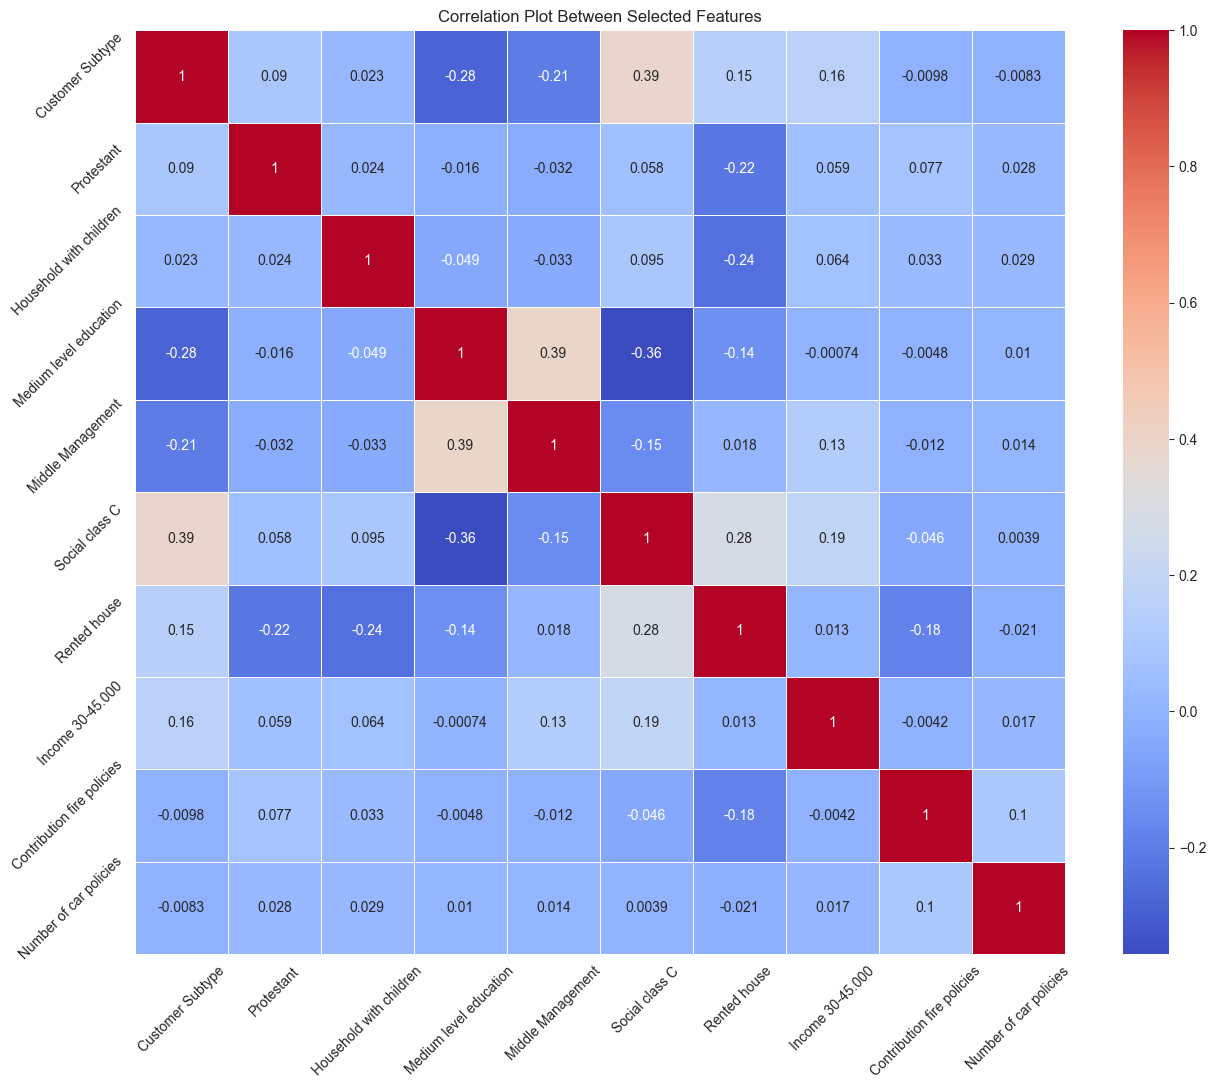

In [28]:
# more generally, we can also try recursive feature elimination on the preliminary selection:

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

rfe = RFE(model, n_features_to_select=10) 
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
print(selected_features)

reduced_x = X[selected_features]
corr_matrix = reduced_x.corr()

plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Plot Between Selected Features')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

for feature in selected_features:
    total_features[feature] += 1


Index(['Married', 'High level education', 'Lower level education', 'Farmer',
       'Rented house', '1 car', 'Average income', 'Purchasing power class',
       'Contribution private third party insurance',
       'Contribution car policies', 'Contribution fire policies',
       'Number of boat policies',
       'Number of social security insurance policies'],
      dtype='object')


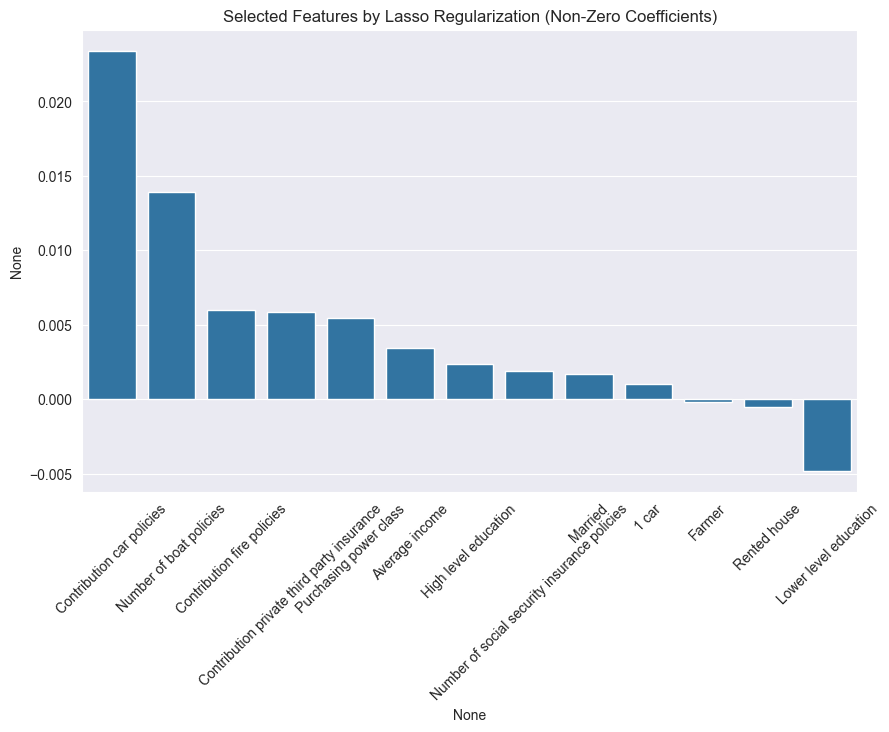

In [18]:
 # there is also the lasso feature selection approach, which will via regularization shrink unimportant features. Interestingly, it selects different features from RFE

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = Lasso(alpha=0.01)  # You can tune the alpha value
lasso.fit(X_scaled, y)

selected_features = X.columns[lasso.coef_ != 0]
print(selected_features)

lasso_coefficients = pd.Series(lasso.coef_, index=X.columns)
lasso_selected = lasso_coefficients[lasso_coefficients != 0].sort_values(ascending=False)

# Plot the selected features
plt.figure(figsize=(10,6))
sns.barplot(x=lasso_selected.index, y=lasso_selected)
plt.title('Selected Features by Lasso Regularization (Non-Zero Coefficients)')
plt.xticks(rotation=45)
plt.show()

for feature in selected_features:
    total_features[feature] += 1

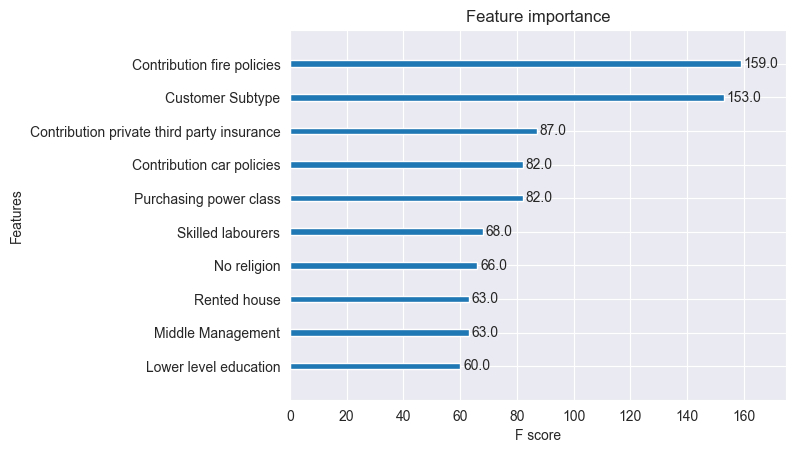

In [19]:
from xgboost import XGBClassifier
import xgboost as xgb
from matplotlib import pyplot as plt

X.columns = X.columns.str.replace(r'[\[\]<]', '', regex=True)

xgb_model = XGBClassifier()
xgb_model.fit(X, y) 

xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

feature_importances = xgb_model.get_booster().get_score(importance_type='weight')

importance_df = pd.DataFrame({
    'feature': list(feature_importances.keys()),
    'importance': list(feature_importances.values())
})

importance_df = importance_df.sort_values(by='importance', ascending=False)

top_features = importance_df['feature'].head(10).tolist()

for feature in top_features:
    total_features[feature] += 1

In [20]:
#print features with more than 0 count and their count
for feature, count in total_features.items():
    if count > 0:  
        print(f"Feature: {feature}, Count: {count}")


Feature: Customer Subtype, Count: 3
Feature: Protestant, Count: 1
Feature: No religion, Count: 2
Feature: Married, Count: 1
Feature: Household with children, Count: 1
Feature: High level education, Count: 2
Feature: Medium level education, Count: 1
Feature: Lower level education, Count: 3
Feature: Farmer, Count: 1
Feature: Middle Management, Count: 2
Feature: Skilled labourers, Count: 1
Feature: Social class C, Count: 1
Feature: Rented house, Count: 4
Feature: Home owners, Count: 1
Feature: 1 car, Count: 1
Feature: Income 30-45.000, Count: 1
Feature: Income 45-75.000, Count: 1
Feature: Average income, Count: 1
Feature: Purchasing power class, Count: 3
Feature: Contribution private third party insurance, Count: 3
Feature: Contribution car policies, Count: 3
Feature: Contribution fire policies, Count: 4
Feature: Contribution boat policies, Count: 1
Feature: Contribution social security insurance policies, Count: 1
Feature: Number of car policies, Count: 2
Feature: Number of boat policies

In [25]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('caravan.csv')

X = df.drop(columns='CARAVAN POLICY')
y = df['CARAVAN POLICY']

X.columns = X.columns.str.replace(r'[\[\]<]', '', regex=True)

# I use grid search to search hyperparameters
pipeline = Pipeline([
    ('lasso', SelectFromModel(LassoCV(cv=5), max_features=20)),  
    ('rfe', RFE(estimator=RandomForestClassifier(), n_features_to_select=10)), 
    ('classifier', XGBClassifier(eval_metric='logloss'))
])


param_grid = {
    'lasso__max_features': [20, 30],                    
    'lasso__estimator__alphas': [(0.1, 1.0, 10.0)],               
    'rfe__n_features_to_select': [5, 10, 15],                      
    'classifier__n_estimators': [50, 100, 200],                      
    'classifier__max_depth': [10, 20],     
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X, y)
print(f"Test set accuracy: {test_accuracy:.4f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\ludwig\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\ludwig\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
38 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ludwig\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fi

Test set accuracy: 0.9402


C:\Users\ludwig\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:05:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [26]:

df_test = pd.read_csv('caravanTest.csv')

X_test = df_test.drop(columns=['CARAVAN POLICY'], errors='ignore')
y_test = df_test['CARAVAN POLICY']

X_test.columns = X.columns.str.replace(r'[\[\]<]', '', regex=True)


best_pipeline = grid_search.best_estimator_

predicted_probabilities = best_pipeline.predict_proba(X_test)[:, 1]

top_800_indices = np.argsort(predicted_probabilities)[-800:]

y_top_800_actual = y_test.iloc[top_800_indices]
true_positives = sum(y_top_800_actual == 1)
accuracy_top_800 = true_positives / 800

print(f"Top 800 accuracy: {accuracy_top_800:.4f}")





Top 800 accuracy: 0.1313
